# HBEC FPR and replication rate

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist//memento-0.1.0-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/hbec/'

### Read the processed RNA data and setup

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [4]:
adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N', 'club':'club'}
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
adata_processed.obs['filtered_expr'] = adata_processed[:, 'CXCL10'].X.reshape(-1)* (adata_processed.obs['time'] == '3')

In [5]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [6]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [7]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Function for running Python-based methods

In [8]:
def evaluate_fpr(count_adata, norm_data, group_col, treatment_col):
    
    memento.setup_memento(count_adata, q_column='q', trim_percent=0.1)
    
    memento.create_groups(count_adata, label_columns=[group_col, treatment_col])
    memento.compute_1d_moments(count_adata, min_perc_group=.5)

    meta_df = memento.get_groups(count_adata)
    meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=True)

    treatment = meta_df[[treatment_col]]
    covariate = meta_df[[x for x in meta_df.columns if x != treatment_col]]
    covariate = pd.concat([covariate, covariate*treatment.values], axis=1)


    memento.ht_1d_moments(
        count_adata, 
        treatment=treatment,
        covariate=covariate,
        num_boot=5000, 
        verbose=1,
        num_cpus=14,
        resample_rep=False,
        approx=True)
   
    result = memento.get_1d_ht_result(count_adata)
    
    genes = list(result.gene.tolist())
    norm_data_overlap = norm_data[:, genes].copy()
                 
    A_data, B_data = norm_data_overlap[norm_data_overlap.obs[treatment_col] == 0].X.todense(), norm_data_overlap[norm_data_overlap.obs[treatment_col] == 1].X.todense()
    _, result['ttest_pval'] = stats.ttest_ind(A_data, B_data, equal_var=False)
#     result['mwu_pval'] = np.array([stats.mannwhitneyu(A_data[:, i], B_data[:,i])[1] for i in range(A_data.shape[1])])
    
    return result

In [9]:
test_adata = adata.copy()[
    adata.obs.time.isin(['0', '6'])&\
    adata.obs.ct.isin(['C']) & \
    adata.obs.stim.isin(['beta', 'control']), :].copy()
stim_converter={'control':0, 'beta':1}
test_adata.obs['stim_indicator'] = test_adata.obs['stim'].apply(lambda x: stim_converter[x])
# sc.pp.subsample(test_adata, n_obs=200)

# test_adata.obs['shuffled_treatment'] = test_adata.obs['stim_indicator'].sample(frac=1.0).tolist()
test_norm_adata = sc.AnnData(adata_processed[test_adata.obs.index].raw.X, test_adata.obs, adata_processed.raw.var)

result_C_beta = evaluate_fpr(test_adata, test_norm_adata, 'donor','stim_indicator')

im here


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    3.5s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    5.8s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:    9.8s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   15.1s
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:   21.6s
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:   29.6s
[Parallel(n_jobs=14)]: Done 2422 tasks      | elapsed:   39.0s
[Parallel(n_jobs=14)]: Done 3172 tasks      | elapsed:   49.9s
[Parallel(n_jobs=14)]: Done 4022 tasks      | elapsed:  1.0min
[Parallel(n_jobs=14)]: Done 4972 tasks      | elapsed:  1.3min
[Parallel(n_jobs=14)]: Done 6022 tasks      | elapsed:  1.5min
[Parallel(n_jobs=14)]: Done 7172 tasks      | elapsed:  1.8min
[Parallel(n_jobs=14)]: Done 8422 tasks      | elapsed:  2.1min
[Parallel(n_jobs=14)]: Done 9772 tasks      | elapsed:  2.4min
[Parallel(n_jobs=14)]: Done 10682 out of 1068

In [22]:
test_adata = adata.copy()[
    adata.obs.time.isin(['0', '6'])&\
    adata.obs.ct.isin(['BC']) & \
    adata.obs.stim.isin(['beta', 'control']), :].copy()
stim_converter={'control':0, 'beta':1}
test_adata.obs['stim_indicator'] = test_adata.obs['stim'].apply(lambda x: stim_converter[x])
# sc.pp.subsample(test_adata, n_obs=200)

# test_adata.obs['shuffled_treatment'] = test_adata.obs['stim_indicator'].sample(frac=1.0).tolist()
test_norm_adata = sc.AnnData(adata_processed[test_adata.obs.index].raw.X, test_adata.obs, adata_processed.raw.var)

result_BC_beta = evaluate_fpr(test_adata, test_norm_adata, 'donor','stim_indicator')

im here


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=14)]: Done 316 tasks      | elapsed:    4.4s
[Parallel(n_jobs=14)]: Done 816 tasks      | elapsed:   11.1s
[Parallel(n_jobs=14)]: Done 1516 tasks      | elapsed:   20.0s
[Parallel(n_jobs=14)]: Done 2416 tasks      | elapsed:   31.8s
[Parallel(n_jobs=14)]: Done 3516 tasks      | elapsed:   46.5s
[Parallel(n_jobs=14)]: Done 4816 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 6316 tasks      | elapsed:  1.4min
[Parallel(n_jobs=14)]: Done 8016 tasks      | elapsed:  1.8min
[Parallel(n_jobs=14)]: Done 8488 out of 8515 | elapsed:  1.9min remaining:    0.4s
[Parallel(n_jobs=14)]: Done 8515 out of 8515 | elapsed:  1.9min finished


In [29]:
merged = result_C_beta.merge(result_BC_beta, on='gene', suffixes=('_C', '_BC')).replace([np.inf, -np.inf], np.nan).dropna()

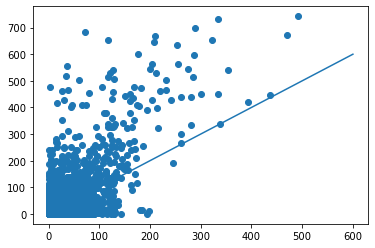

In [25]:
plt.scatter(-np.log(merged['ttest_pval_C']), -np.log(merged['ttest_pval_BC']))
plt.plot([0, 600], [0, 600])

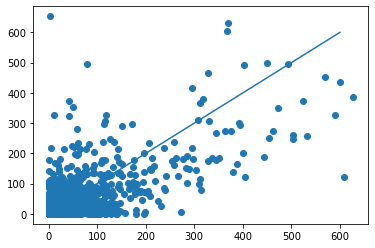

In [26]:
plt.scatter(-np.log(merged['de_pval_C']), )
plt.plot([0, 600], [0, 600])

In [35]:
stats.pearsonr(-np.log(merged['ttest_pval_C']+1e-50), -np.log(merged['ttest_pval_BC']+1e-50))

(0.6592276863534976, 0.0)

In [34]:
stats.pearsonr(-np.log(merged['de_pval_C']+1e-50), -np.log(merged['de_pval_BC']+1e-50))

(0.657399539530646, 0.0)

In [48]:
merged['memento_fdr_C'] = memento.util._fdrcorrect(merged['de_pval_C'])
merged['memento_fdr_BC'] = memento.util._fdrcorrect(merged['de_pval_BC'])

merged['ttest_fdr_C'] = memento.util._fdrcorrect(merged['ttest_pval_C'])
merged['ttest_fdr_BC'] = memento.util._fdrcorrect(merged['ttest_pval_BC'])

In [49]:
merged['memento_hit'] = (merged['memento_fdr_BC'] < 0.01)
merged['ttest_hit'] = (merged['ttest_fdr_BC'] < 0.01)

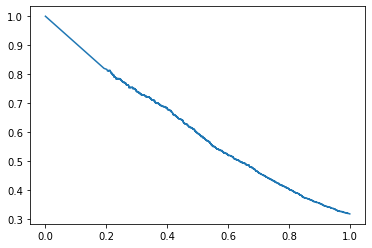

In [51]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(merged['memento_hit'], 1-merged['memento_fdr_C'])
plt.plot(recall, precision)
plt.title('memento')

Text(0.5, 1.0, 'ttest')

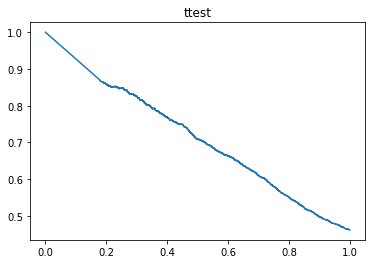

In [52]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(merged['ttest_hit'], 1-merged['ttest_fdr_C'])
plt.plot(recall, precision)
plt.title('ttest')

In [42]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(, merged['memento_hit'], name="memento")
_ = display.ax_.set_title("2-class Precision-Recall curve")

AttributeError: type object 'PrecisionRecallDisplay' has no attribute 'from_predictions'

In [ ]:
test_adata = adata.copy()[
    adata.obs.time.isin(['0', '6'])&\
    adata.obs.ct.isin(['BC']) & \
    adata.obs.stim.isin(['beta', 'control']), :].copy()
stim_converter={'control':0, 'beta':1}
test_adata.obs['stim_indicator'] = test_adata.obs['stim'].apply(lambda x: stim_converter[x])
sc.pp.subsample(test_adata, n_obs=200)

test_adata.obs['shuffled_treatment'] = test_adata.obs['stim_indicator'].sample(frac=1.0).tolist()
test_norm_adata = sc.AnnData(adata_processed[test_adata.obs.index].raw.X, test_adata.obs, adata_processed.raw.var)

result_C = evaluate_fpr(test_adata, test_norm_adata, 'donor','stim_indicator')